# Importing necessary libraries and stock data

In [ ]:
pip install yfinance

In [4]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math
import pandas as pd
import numpy as np
from IPython.display import display
import time

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb

from keras.layers import *
from keras.models import Sequential, Model

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K

import warnings
warnings.filterwarnings('ignore')

In [5]:

# Define Date Ranges
start_date = '2005-01-01'
end_date = '2020-12-31'

# Fetch the stock data
ticker_symbol = 'GOOG'
stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Display the data
stock_data


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-03-27,28.322241,28.322241,27.570307,27.846546,27.814894,262719
2014-03-28,27.983171,28.243956,27.857019,27.922838,27.891100,824257
2014-03-31,28.266893,28.272379,27.770258,27.772251,27.740683,216593
2014-04-01,27.859013,28.344681,27.859013,28.280355,28.248211,158434
2014-04-02,29.917362,30.158699,28.032537,28.272379,28.240242,2942055
...,...,...,...,...,...,...
2020-12-23,86.405502,87.399498,86.251999,86.619003,86.520546,20676000
2020-12-24,86.750000,87.300003,86.455498,86.942497,86.843674,6936000
2020-12-28,87.581749,89.536400,87.316750,88.804497,88.703560,27860000


# Plotting basic regression

In [6]:
data=stock_data.copy()
data = data.reset_index()

In [7]:
# Split data into train and test set: 80% / 20%
train, test = train_test_split(data, test_size=0.20)
# Reshape index column to 2D array for .fit() method
X_train = np.array(train.index).reshape(-1, 1)
y_train = train['Adj Close']
# Create LinearRegression Object
model = LinearRegression()
# Fit linear model using the train data set
model.fit(X_train, y_train)

LinearRegression()

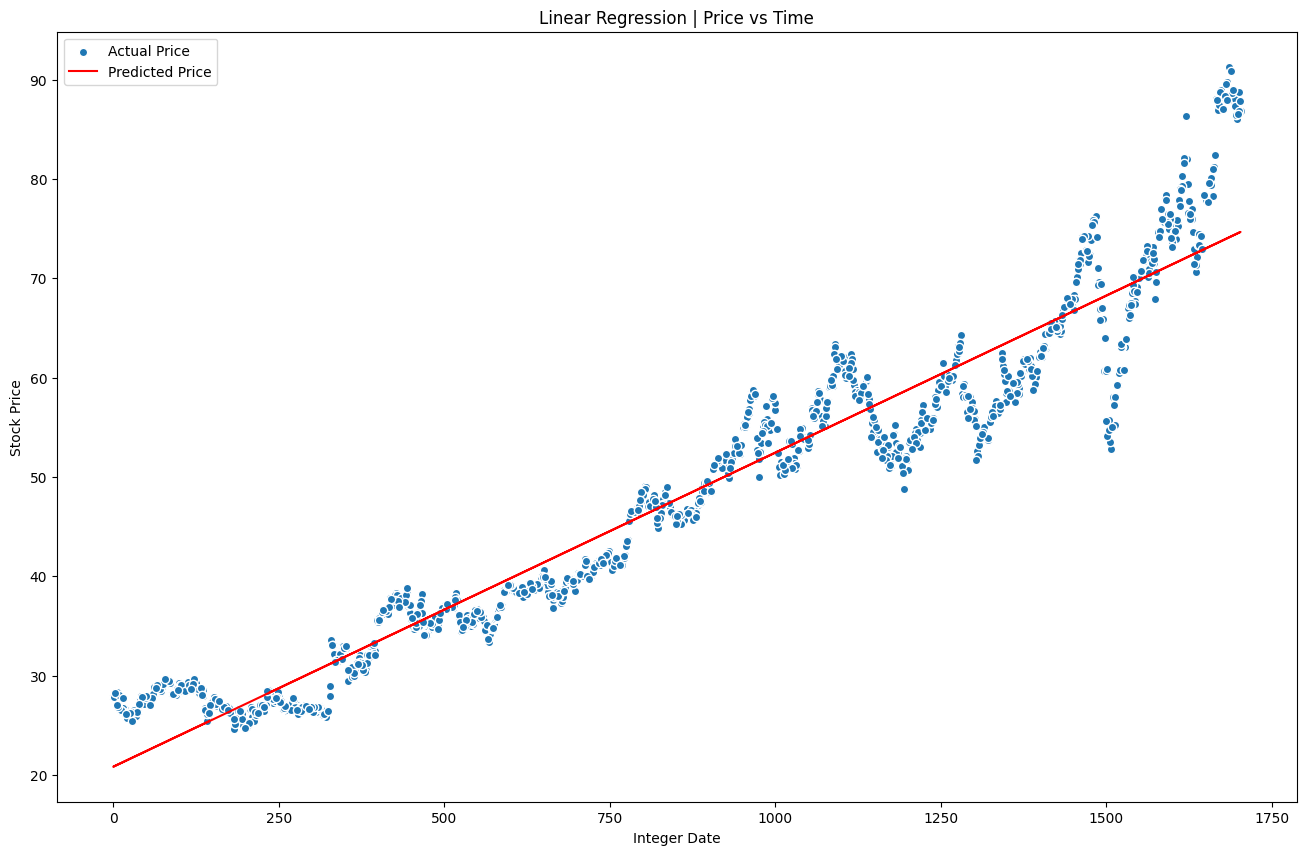

In [8]:
# Train set graph
plt.figure(1, figsize=(16,10))
plt.title('Linear Regression | Price vs Time')
plt.scatter(X_train, y_train, edgecolor='w', label='Actual Price')
plt.plot(X_train, model.predict(X_train), color='r', label='Predicted Price')
plt.xlabel('Integer Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [9]:
# Create test arrays
X_test = np.array(test.index).reshape(-1, 1)
y_test = test['Close']
# Generate array with predicted values
y_pred = model.predict(X_test)

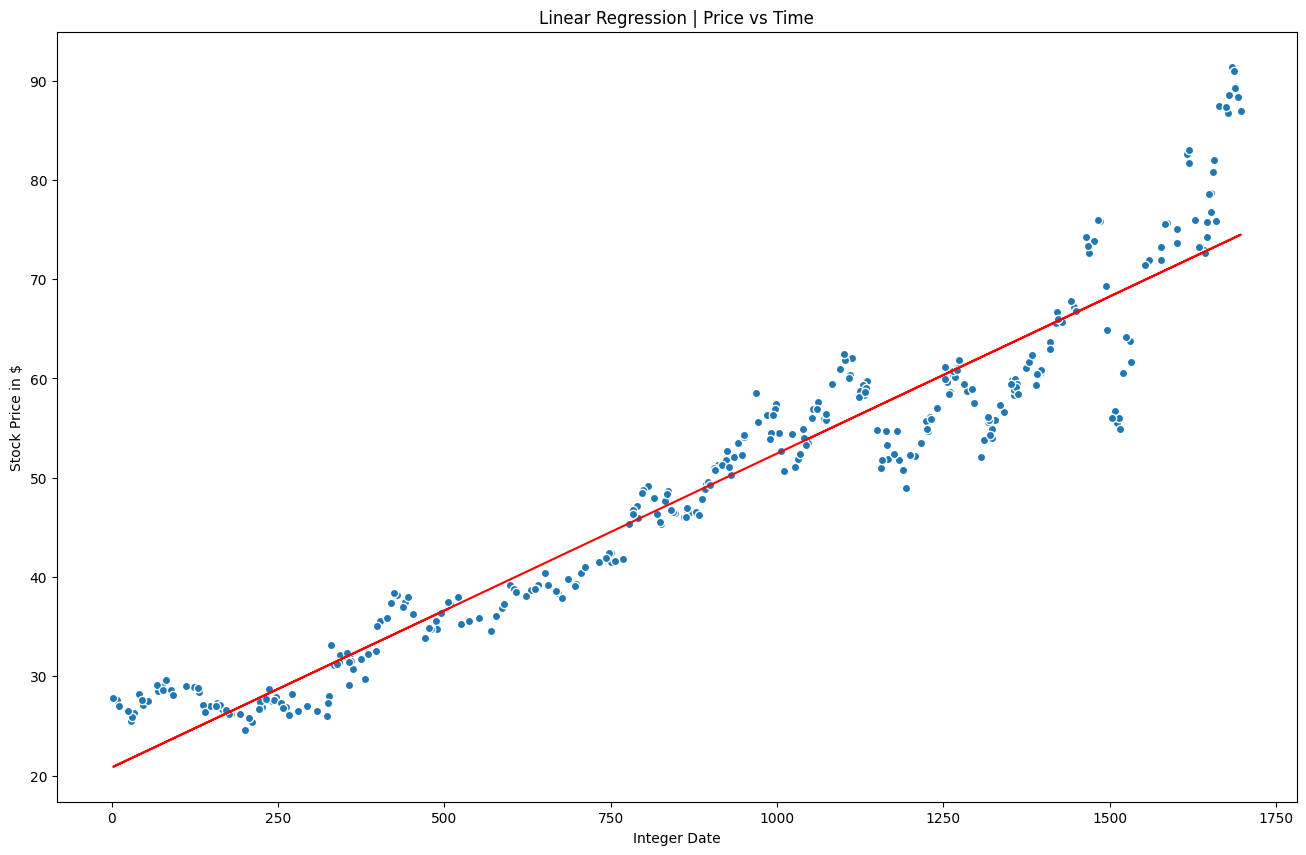

In [10]:
# Plot fitted line, y test
plt.figure(1, figsize=(16,10))
plt.title('Linear Regression | Price vs Time')
plt.plot(X_test, model.predict(X_test), color='r', label='Predicted Price')
plt.scatter(X_test, y_test, edgecolor='w', label='Actual Price')

plt.xlabel('Integer Date')
plt.ylabel('Stock Price in $')

plt.show()

# Training LSTM network with previous close and volume data using log normalisation

In [11]:
seq_length = 60
step_predict = 5

In [12]:
df=stock_data.copy()
df['close_log'] = np.log(df['Close'] / df['Close'].shift(1))
df['vol_log'] = np.log(df['Volume'] / df['Volume'].shift(1))
df['target_log'] = np.log(df['Close'].shift(-step_predict) / df['Close'])
df = df.reset_index(drop=True)
df.dropna(inplace=True)
length=df.shape[0]
df

,Open,High,Low,Close,Adj Close,Volume,close_log,vol_log,target_log
1,27.983171,28.243956,27.857019,27.922838,27.891100,824257,0.002736,1.143397,-0.030552
2,28.266893,28.272379,27.770258,27.772251,27.740683,216593,-0.005408,-1.336462,-0.034374
3,27.859013,28.344681,27.859013,28.280355,28.248211,158434,0.018130,-0.312682,-0.021853
4,29.917362,30.158699,28.032537,28.272379,28.240242,2942055,-0.000282,2.921525,-0.005057
5,28.414488,29.283602,28.129271,28.409002,28.376711,101983228,0.004821,3.545700,-0.051853
...,...,...,...,...,...,...,...,...,...
1694,88.643997,88.650002,87.804001,88.150002,88.049805,30270000,-0.002702,0.020830,-0.017521
1695,88.425499,88.589203,86.932999,87.394997,87.295662,32494000,-0.008602,0.070898,-0.005191
1696,87.709000,87.755501,86.011002,86.550499,86.452118,80328000,-0.009710,0.905063,0.025709
1697,85.675499,87.042503,84.949997,86.968498,86.869644,36568000,0.004818,-0.786945,0.011063


In [13]:
train_df = df[:int(length*0.75)].copy()
train_df.reset_index(inplace=True)
val_df = df[int(length*0.75):int(length*0.8)].copy()
val_df.reset_index(inplace=True)
test_df = df.loc[int(length*0.8):].copy()
test_df.reset_index(inplace=True)
train_df.shape, val_df.shape, test_df.shape

((1273, 10), (85, 10), (341, 10))

In [14]:
X_train = []
y_train = []
for i in range(seq_length, train_df.shape[0]-step_predict):
    X_train.append(train_df[i-seq_length+1: i][['close_log', 'vol_log']].values)
    y_train.append(train_df.loc[i-1, 'target_log'])
X_train, y_train= np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 2))
X_train.shape, y_train.shape

((1208, 59, 2), (1208,))

In [15]:
X_val = []
y_val = []
for i in range(seq_length, val_df.shape[0]-step_predict):
    X_val.append(val_df[i-seq_length+1: i][['close_log', 'vol_log']].values)
    y_val.append(val_df.loc[i-1, 'target_log'])
X_val, y_val= np.array(X_val), np.array(y_val)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 2))
X_val.shape, y_val.shape

((20, 59, 2), (20,))

In [16]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [17]:
inputs = Input(shape=(X_train.shape[1], 2))
lstm1 = LSTM(units=50, return_sequences=True)(inputs)
dropout1 = Dropout(rate=0.5)(lstm1)
lstm2 = LSTM(units=50, return_sequences=True)(dropout1)
dropout2 = Dropout(rate=0.5)(lstm2)
lstm3 = LSTM(units=50)(dropout2)
dropout3 = Dropout(rate=0.5)(lstm3)
fc1 = Dense(units=100)(dropout3)
fc2 = Dense(units=50)(fc1)
fc3 = Dense(units=25)(fc2)
output = Dense(units=1)(fc3)

lstm_model = Model(inputs=inputs, outputs=output)
lstm_model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = lstm_model.fit(X_train, y_train, epochs = 20, batch_size = 32, validation_data=(X_val, y_val))

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0010 - val_loss: 0.0021
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 9/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 10/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0010 - val_loss: 0.0022
Epoch 11/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 12/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 9.

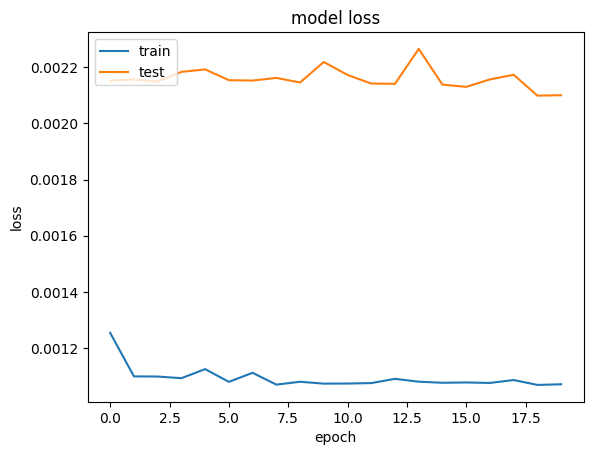

In [20]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
train_price = train_df[seq_length+step_predict:train_df.shape[0]].Close
train_predicted = lstm_model.predict(X_train)
# train_predicted = sc.inverse_transform(train_predicted)
inv = train_df[seq_length:train_df.shape[0]-step_predict].Close.values.reshape(-1, 1)
train_predicted = inv * np.exp(1)**train_predicted
len(train_price), len(train_predicted)

38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step


(1208, 1208)

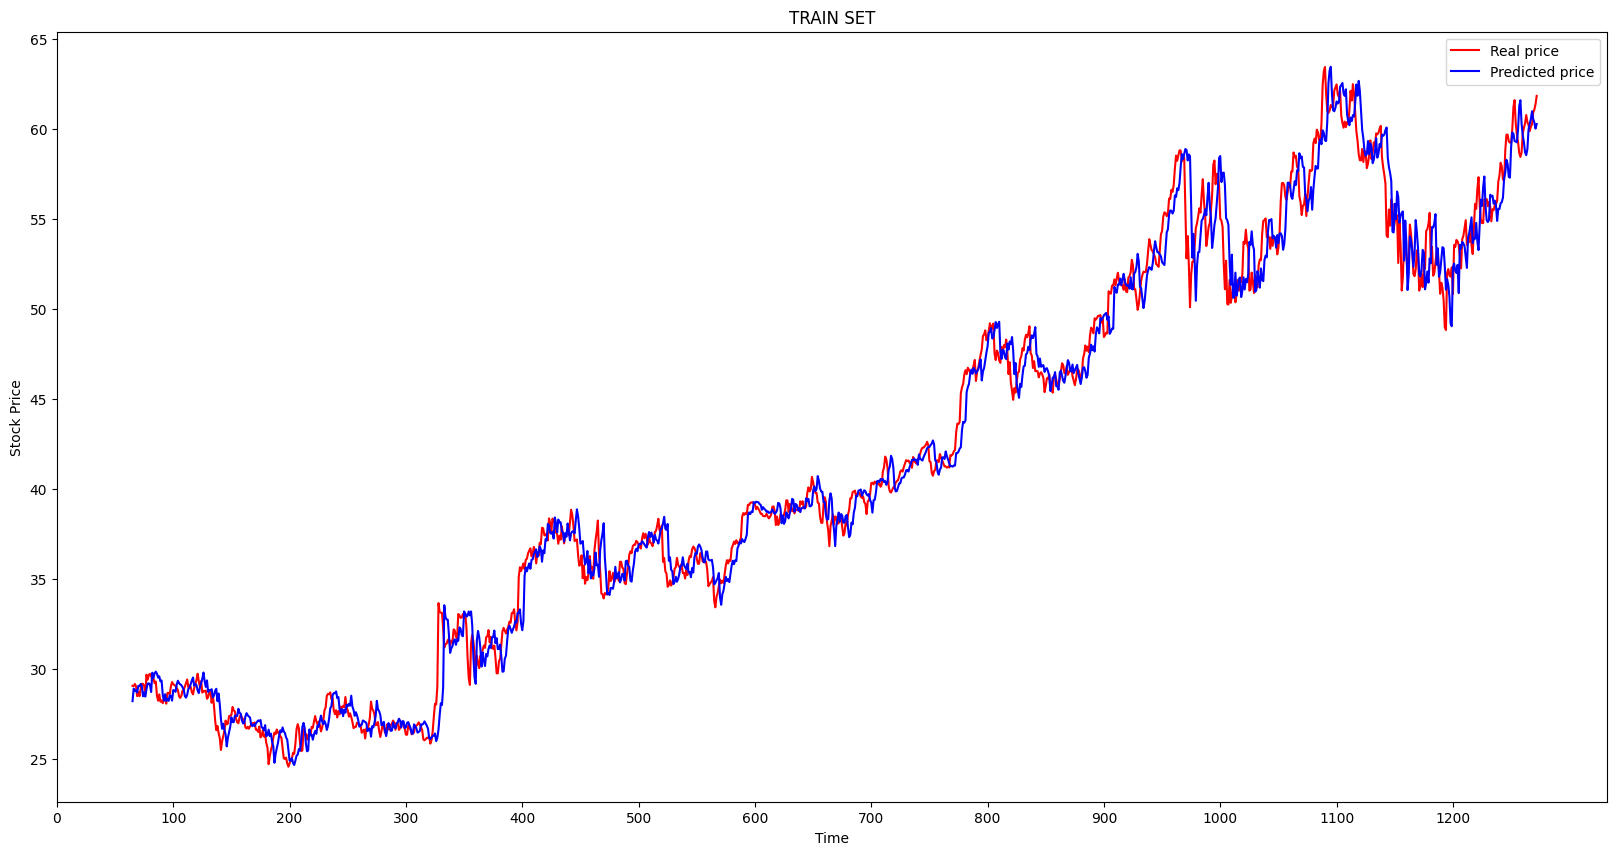

RMSE: 1.3698256133591291


In [22]:
# Visualising the results
date = train_df[seq_length+step_predict:train_df.shape[0]].index.values
plt.figure(figsize=(20,10))
plt.plot(date, train_price, color = 'red', label = 'Real price')
plt.plot(date, train_predicted, color = 'blue', label = 'Predicted price')
plt.xticks(np.arange(0,len(train_predicted),100))
plt.title('TRAIN SET')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
print(f'RMSE: {mean_squared_error(train_price, train_predicted, squared=False)}')

In [25]:
X_test = []
y_test = []
for i in range(seq_length, test_df.shape[0]-step_predict):
    X_test.append(test_df[i-
                          +1: i][['close_log', 'vol_log']].values)
    y_test.append(test_df.loc[i-1, 'target_log'])
X_test, y_test= np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 2))
X_test.shape, y_test.shape

((276, 1, 2), (276,))

In [26]:
test_price = test_df[seq_length+step_predict:test_df.shape[0]].Close
test_predicted = lstm_model.predict(X_test)
# test_predicted = sc.inverse_transform(test_predicted)
inv = test_df[seq_length:test_df.shape[0]-step_predict].Close.values.reshape(-1, 1)
test_predicted = inv * np.exp(1)**test_predicted
len(test_price), len(test_predicted)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  


(276, 276)

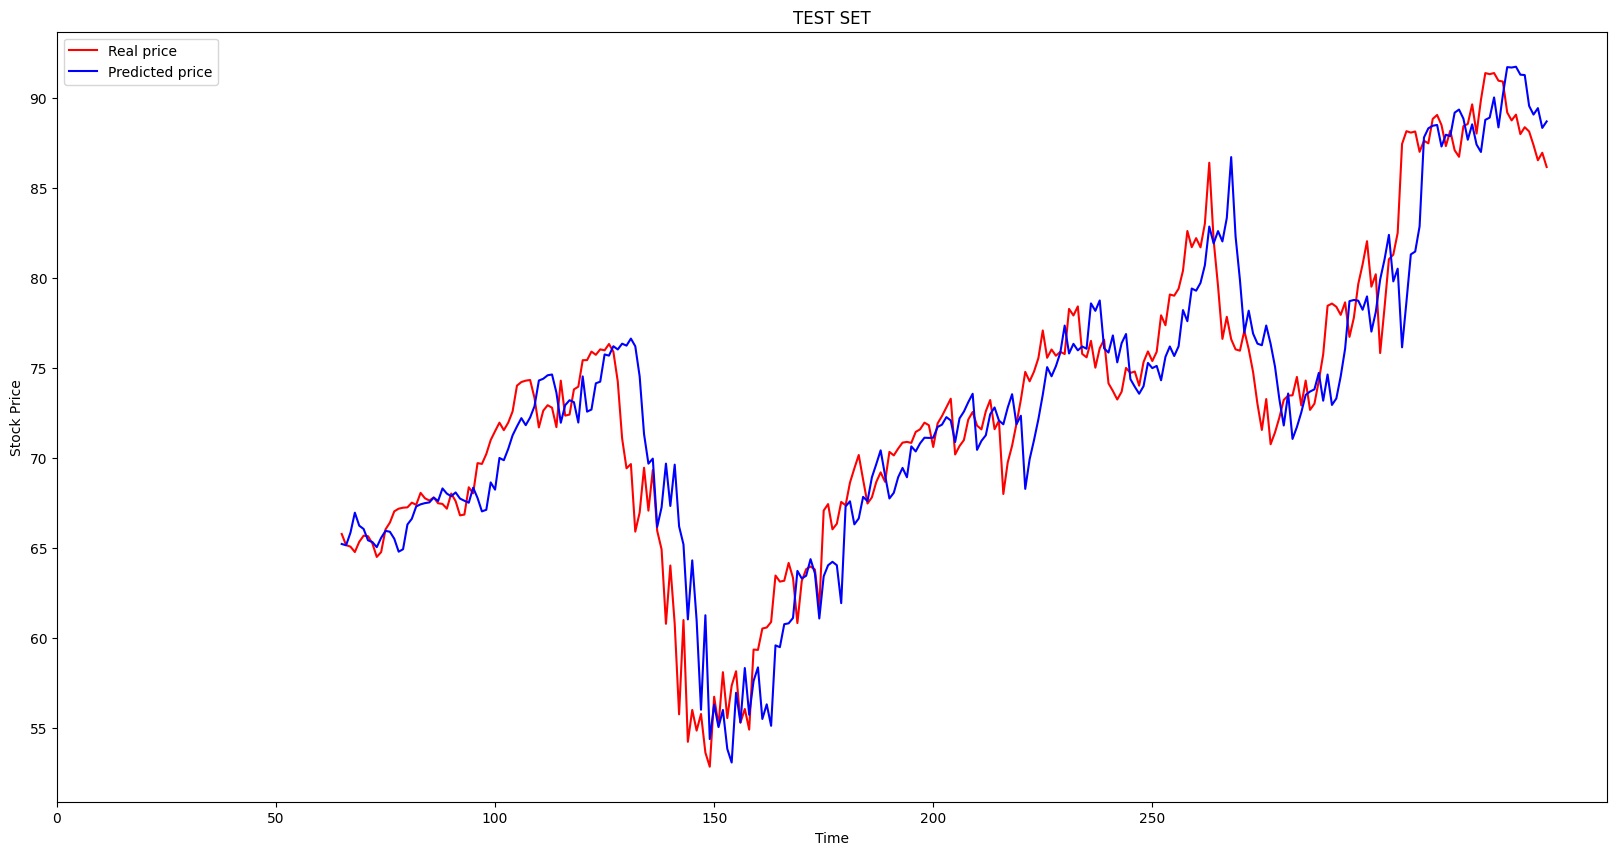

RMSE: 3.031264365119647


In [27]:
# Visualising the results
date = test_df[seq_length+step_predict:test_df.shape[0]].index.values
plt.figure(figsize=(20,10))
plt.plot(date, test_price, color = 'red', label = 'Real price')
plt.plot(date, test_predicted, color = 'blue', label = 'Predicted price')
plt.xticks(np.arange(0,len(test_predicted),50))
plt.title('TEST SET')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
print(f'RMSE: {mean_squared_error(test_price, test_predicted, squared=False)}')

# Some More Features Added

In [31]:
#Created a new dataframe and added a variety of relevant technical indicators so as to make accurate predictions 

df = stock_data.copy()

# Add Year, Month, and Day columns
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day

# Calculate 14-day Simple Moving Average (SMA) using 'Adj Close'
df['SMA_14'] = df['Adj Close'].rolling(window=14).mean()

# Calculate 14-day Exponential Moving Average (EMA) using 'Adj Close'
df['EMA_14'] = df['Adj Close'].ewm(span=14, adjust=False).mean()

# Calculate Cumulative Moving Average (CMA) using 'Adj Close'
df['CMA'] = df['Adj Close'].expanding().mean()

# Calculate Daily Return
df['Daily Return'] = df['Adj Close'].pct_change()

# Calculate MACD
df['EMA_12'] = df['Adj Close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['Adj Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA_12'] - df['EMA_26']





In [67]:
# RSI (14-day)
change = df["Adj Close"].diff()
change.dropna(inplace=True)
change_up = change.copy()
change_down = change.copy()
change_up[change_up<0] = 0
change_down[change_down>0] = 0
change.equals(change_up+change_down)
avg_up = change_up.rolling(14).mean()
avg_down = change_down.rolling(14).mean().abs()
rsi = 100 * avg_up / (avg_up + avg_down)
df['RSI'] = rsi
df.RSI=df.RSI.fillna(df.RSI.median())


In [68]:
df.dropna(inplace=True)
df.drop(['EMA_12','EMA_26'], axis =1)

,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day,SMA_14,EMA_14,CMA,Daily Return,MACD,RSI
Date,,,,,,,,,,,,,,,
2014-04-15,26.767509,26.848787,25.852022,26.748562,26.718159,77101101,2014,4,15,27.465254,27.272984,27.465254,0.007361,-0.274578,54.919323
2014-04-16,27.075665,27.773746,26.926073,27.750811,27.719267,97865955,2014,4,16,27.458424,27.332488,27.482188,0.037469,-0.213639,54.919323
2014-04-17,27.365368,27.399775,26.484785,26.731607,26.701223,136190888,2014,4,17,27.373432,27.248320,27.433378,-0.036727,-0.244672,54.919323
2014-04-21,26.731607,26.761526,26.208046,26.358631,26.328671,51334553,2014,4,21,27.272574,27.125700,27.368395,-0.013953,-0.295917,54.919323
2014-04-22,26.359631,26.787954,26.303284,26.667286,26.636974,47307527,2014,4,22,27.157486,27.060536,27.327761,0.011710,-0.308099,54.919323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,86.405502,87.399498,86.251999,86.619003,86.520546,20676000,2020,12,23,88.371722,87.693600,47.668498,0.005152,0.111698,20.430999
2020-12-24,86.750000,87.300003,86.455498,86.942497,86.843674,6936000,2020,12,24,88.053726,87.580276,47.691528,0.003735,0.044395,22.964874
2020-12-28,87.581749,89.536400,87.316750,88.804497,88.703560,27860000,2020,12,28,87.898938,87.730047,47.715625,0.021416,0.139526,38.793325


# Building improved LSTM model using selected features 

In [69]:
train_data=df.copy()
train_data

,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day,SMA_14,EMA_14,CMA,Daily Return,EMA_12,EMA_26,MACD,RSI
Date,,,,,,,,,,,,,,,,,
2014-04-15,26.767509,26.848787,25.852022,26.748562,26.718159,77101101,2014,4,15,27.465254,27.272984,27.465254,0.007361,27.210321,27.484899,-0.274578,54.919323
2014-04-16,27.075665,27.773746,26.926073,27.750811,27.719267,97865955,2014,4,16,27.458424,27.332488,27.482188,0.037469,27.288621,27.502260,-0.213639,54.919323
2014-04-17,27.365368,27.399775,26.484785,26.731607,26.701223,136190888,2014,4,17,27.373432,27.248320,27.433378,-0.036727,27.198252,27.442924,-0.244672,54.919323
2014-04-21,26.731607,26.761526,26.208046,26.358631,26.328671,51334553,2014,4,21,27.272574,27.125700,27.368395,-0.013953,27.064470,27.360387,-0.295917,54.919323
2014-04-22,26.359631,26.787954,26.303284,26.667286,26.636974,47307527,2014,4,22,27.157486,27.060536,27.327761,0.011710,26.998702,27.306801,-0.308099,54.919323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,86.405502,87.399498,86.251999,86.619003,86.520546,20676000,2020,12,23,88.371722,87.693600,47.668498,0.005152,87.583645,87.471947,0.111698,20.430999
2020-12-24,86.750000,87.300003,86.455498,86.942497,86.843674,6936000,2020,12,24,88.053726,87.580276,47.691528,0.003735,87.469803,87.425408,0.044395,22.964874
2020-12-28,87.581749,89.536400,87.316750,88.804497,88.703560,27860000,2020,12,28,87.898938,87.730047,47.715625,0.021416,87.659612,87.520086,0.139526,38.793325


In [70]:
prediction_time=5
test_data_size=int(0.2*train_data.shape[0])
unroll_length=60

test_data_cut = test_data_size + unroll_length + 1

x_train = train_data[0:-prediction_time - test_data_cut].values
y_train = train_data[prediction_time:-test_data_cut]['Close'].values

# test data
x_test = train_data[0 - test_data_cut:-prediction_time].values
y_test = train_data[prediction_time - test_data_cut:]['Close'].values

x_train.shape, x_test.shape, y_train.shape, y_test.shape


((1287, 17), (394, 17), (1287,), (394,))

In [71]:

# Create separate scalers for each dataset
scaler_x_train = MinMaxScaler()
scaler_x_test = MinMaxScaler()
scaler_y_train = MinMaxScaler()
scaler_y_test = MinMaxScaler()

# Apply the scalers to the datasets
x_train = scaler_x_train.fit_transform(x_train)
x_test = scaler_x_test.fit_transform(x_test)
y_train = scaler_y_train.fit_transform(y_train.reshape(-1, 1))
y_test = scaler_y_test.fit_transform(y_test.reshape(-1, 1))

# If you need to inverse transform later, you can use the same scalers
# y_train_original = scaler_y_train.inverse_transform(y_train_scaled)
# y_test_original = scaler_y_test.inverse_transform(y_test_scaled)


In [72]:
def unroll(data, sequence_length=24):
    """
    use different windows for testing and training to stop from leak of information in the data
    :param data: data set to be used for unrolling
    :param sequence_length: window length
    :return: data sets with different window.
    """
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

x_train = unroll(x_train, unroll_length)
x_test = unroll(x_test, unroll_length)

In [73]:
y_train = y_train[-x_train.shape[0]:]
y_test = y_test[-x_test.shape[0]:]

In [74]:
print(x_train.shape,y_train.shape)

(1227, 60, 17) (1227, 1)


In [75]:
def plot_prediction(actual, prediction, title='Google Trading vs Prediction', y_label='Price USD', x_label='Trading Days'):
    """
    Plots train, test and prediction
    :param actual: DataFrame containing actual data
    :param prediction: DataFrame containing predicted values
    :param title:  Title of the plot
    :param y_label: yLabel of the plot
    :param x_label: xLabel of the plot
    :return: prints a Pyplot againts items and their closing value
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Add labels
    plt.ylabel(y_label)
    plt.xlabel(x_label)

    # Plot actual and predicted close values

    plt.plot(actual, '#00FF00', label='Adjusted Close')
    plt.plot(prediction, '#0000FF', label='Predicted Close')

    # Set title
    ax.set_title(title)
    ax.legend(loc='upper left')


    plt.show()

In [76]:

def build_improved_model(input_dim, output_dim, return_sequences):
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=(None, input_dim))) 
    model.add(LSTM(units=128)) 
    model.add(Dense(64)) 
    model.add(Dropout(0.2)) 
    model.add(Dense(1)) 
    return model

In [77]:
batch_size = 100 #Mini batch gradient descent
epochs = 50

# build improved lstm model
model_imp = build_improved_model( x_train.shape[-1],output_dim = unroll_length, return_sequences=True)

start = time.time()
model_imp.compile(loss='mean_squared_error', optimizer='adam')

print('compilation time : ', time.time() - start)

compilation time :  0.004388332366943359


In [78]:
model_imp.fit(x_train, 
          y_train, 
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_split=0.05
         )

Epoch 1/50
12/12 - 7s - 549ms/step - loss: 0.0404 - val_loss: 0.0042
Epoch 2/50
12/12 - 2s - 197ms/step - loss: 0.0074 - val_loss: 0.0048
Epoch 3/50
12/12 - 2s - 195ms/step - loss: 0.0047 - val_loss: 0.0040
Epoch 4/50
12/12 - 2s - 199ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 5/50
12/12 - 2s - 196ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 6/50
12/12 - 2s - 200ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 7/50
12/12 - 2s - 199ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 8/50
12/12 - 2s - 200ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 9/50
12/12 - 2s - 200ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 10/50
12/12 - 2s - 199ms/step - loss: 0.0029 - val_loss: 0.0039
Epoch 11/50
12/12 - 2s - 198ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 12/50
12/12 - 2s - 199ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 13/50
12/12 - 2s - 201ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 14/50
12/12 - 3s - 218ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 15/50
12/12 - 2s - 194m

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step


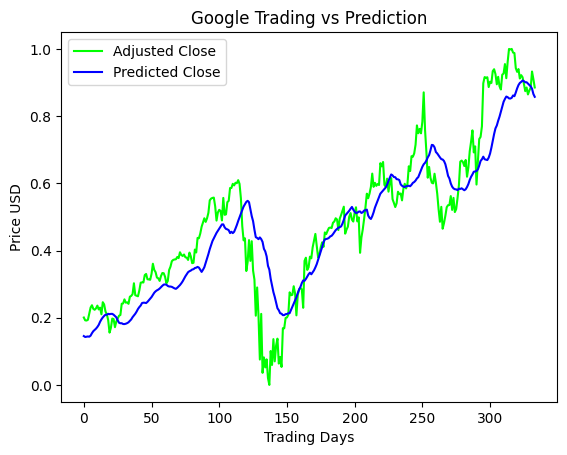

In [79]:
predictions = model_imp.predict(x_test, batch_size=batch_size)
plot_prediction(y_test,predictions)

In [80]:
trainScore = model_imp.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.8f MSE (%.8f RMSE)' % (trainScore, math.sqrt(trainScore)))

testScore = model_imp.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.8f MSE (%.8f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.00206190 MSE (0.04540820 RMSE)
Test Score: 0.01064525 MSE (0.10317581 RMSE)
